# Project Overview

## Lecture

- What is an image classification task? Define input-output and one metric.
- What is an object localization task? Define input-output and one metric.
- What is an object detection task? Define input-output and one metric.
- What is an object recognition task? Define input-output and one metric.
- What is bounding box regression?
- What is non-max suppression?

# Step 1: Import Modules  
Import each module we will use throughout the project.

In [1]:
import os
import numpy as np
import cv2
import tqdm
import json
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


# Step 2: Create **Dataset**

## Lecture

There are 3 different data in DL: 

1. Train
2. Dev/Val (Development/Validation)
3. Test

In the previous era, data distribution is like ~60/20/20 respectively. Now, ~98/1/1 and similar distributions are okay. 

- Why? What is the difference?

Another essential aspect is shaped around the specification. For example, if we would like to design a cat classification model for a mobile app. The training set may include cat pictures from web pages. However, Dev and Test set consists of cat pictures from users using your application. In other words, the dev and test set should come from the same distribution. To sum, choose dev and test set as if they reflect data we expect to get in the future.

- Why having data in a training set whose source is different is okay? In other words, why it does not harm the model?

> In some papers, the researchers use only train and test sets: Not validation sets. The test set gives us an unbiased estimate of performance. If we do not need that unbiased estimate (which is not suggested), we do not have to use a test set. However, if the researcher uses this test set as a hold-out cross-validation method, the terminology is confusing. They are using train and dev set.

## Practice

There is a pipeline for this section:

1. Write a helper function that extracts the traffic sign bounding boxes.
2. Check the function. 
3. Write down into the txt file with the image name.  
4. Split train, dev, and test set. 


In [2]:
""" Write a helper function that extracts the traffic sign bounding boxes """


def json2od(json_name, base_dir):
    """
    Extract Traffic Sign & Traffic Light labels from json.
    Parameters
    ----------
    json_name : string
        Json file name.
    base_dir : string
        Path to json folders.
    Returns
    -------
    list
        Includes 2D label information.
    """
    json_path = os.path.join(base_dir, json_name)
    
    # Read json file
    with open(json_path, 'r') as f:
        jsonfile = json.load(f)
        objects = jsonfile['objects']
        
        # If there is no object in the image, return NULL
        if len(objects) == 0:
            return NULL
        
        # Create empty list
        annotations = []
        for obj in objects:
            if obj['classTitle']=='Traffic Sign':
                obj_class_pts = obj['points']['exterior']
                obj_id = 0
                
                # Eliminate small ones 
                if (obj_class_pts[1][0] - obj_class_pts[0][0]) < 16 or (obj_class_pts[1][1] - obj_class_pts[0][1]) < 16:
                    continue
                
                # Add into list
                strlabel = str(obj_class_pts[0][0]) + ',' + str(obj_class_pts[0][1]) + ',' + str(obj_class_pts[1][0]) + ',' + str(obj_class_pts[1][1]) + ',' + str(obj_id)
                annotations.append(strlabel)
    
    # Modify list
    strlabel = ''
    for idx in range(len(annotations)):
        if idx != 0:
            strlabel += ' '

        strlabel += annotations[idx]

    return strlabel

In [3]:
""" Check the function """ 

# Constants
ROOT_DIR = "data/"
JSON_DIR = os.path.join(ROOT_DIR, "jsons")
json_list = os.listdir(JSON_DIR)

# For 5 json files
for json_name in tqdm.tqdm(json_list[:5]):
    # Display the function output
    print(json2od(json_name, JSON_DIR))


100%|██████████| 5/5 [00:00<00:00, 3632.69it/s]

387,542,438,591,0 666,336,794,525,0 1101,539,1125,562,0
821,0,1613,230,0 787,57,1008,315,0 1015,146,1269,275,0 1280,75,1611,230,0
863,431,937,499,0 794,497,858,538,0 1094,563,1129,599,0 809,570,828,600,0
679,503,716,537,0 645,536,672,556,0
757,493,801,524,0 814,493,855,526,0


In [4]:
""" Write down into the txt file """


IMAGE_DIR = os.path.join(ROOT_DIR,"images")
OD_LABEL = os.path.join(ROOT_DIR, "allLabel.txt")
# Open txt file
f = open(OD_LABEL, "w+")

# For every json file
for json_name in tqdm.tqdm(json_list):
    image_name = os.path.splitext(json_name)[0]
    # Change from png to jpg
    image_name = os.path.splitext(image_name)[0] + ".jpg"
    # Construct Line
    image_path = os.path.join(IMAGE_DIR, image_name)
    line = image_path+' '+json2od(json_name, JSON_DIR)+'\n'
    # Write down
    f.write(line)

# Close txt file
f.close()

100%|██████████| 12/12 [00:00<00:00, 1593.23it/s]


After checking the data folder whether the "allLabel.txt" is created or not, next, we will create a train, dev, and test data by using this file. A number of the positive and negative data could be found by checking the line whether there is bounding box information or not. At the end of the part, we should have three different text files whose names are following:

- train.txt
- valid.txt
- test.txt

Data structure is same with the allLabel.txt: "<image path name> <X,Y,X,Y,ClassID> ...(if there are more than traffic sign)"

> Be careful about val and test data distribution!

In [5]:
""" Split train, dev, and test set """ 

train_file = open("train.txt", "w+")
valid_file = open("valid.txt", "w+")
test_file = open("test.txt", "w+")

## TO DO ##

# Step 2: Determine Metric(s)

## Lecture

There are two types of metrics:

1. Satisficing: Conditioning metric.
2. Optimizing: Maximized or minimized metric.

For example, we would like to have the highest accuracy in our model, but it is real-time, so the running time should be smaller than 100 ms. Then, our goal becomes "maximize accuracy subject to running time smaller than 100 ms". "accuracy" and "running time" are optimizing and satisficing metrics, respectively.

If we have N metrics, one of them is optimizing and the rest (N-1) are satisficing.

# Step 3: Perform Data Visualization

## Lecture

One of the factors that make your work valuable is the way you present it. For those who deal with eye-catching data such as images and videos, this presentation can become even easier.

Visualization is important not only for the audience but also for us. Thanks to visualization, we have a chance to control.

## Practice

1. Write a helper function for visualization with bounding box:

    1. Read one line from one of the text files.
    2. Call the image.
    3. Draw rectangular(s) onto the image
    4. Show the bounding-boxed image. 
    5. (If you want) Save it.
2. Check the function
3. Write a helper function to crop the bounding box and return cropped image
4. Check the function

In [6]:
""" Write a helper function for visualization """


def visualize(line, save = False):
    """
    

    Parameters
    ----------
    line : string
        The line includes the image path, objects' bounding box information, object class ID respectively.
    save : bool, optional
        Option to save the image. The default is False.

    Returns
    -------
    None.

    """
    splitted_line = line.split(" ")
    # Check whether there is an object
    if (len(splitted_line)== 1):
        print("There is no object")
    else:
        # Call the image
        image_path = splitted_line[0]
        
        image = cv2.imread(image_path)
        
        # For each object
        for box in splitted_line[1:]:
            [X_up, Y_up, X_bottom, Y_bottom, classID] = box.split(',')
            # Draw rectangle
            cv2.rectangle(image, (int(X_up), int(Y_up)), (int(X_bottom),int(Y_bottom)),
                              color=(0, 255, 0), 
                              thickness=2)
        #Show the image with matplotlib
        plt.imshow(image)
        plt.show()
    
    if save:
        updated_image_path = os.path.splitext(image_path)[0]+"_box.jpg"
        cv2.imwrite(updated_image_path, image)

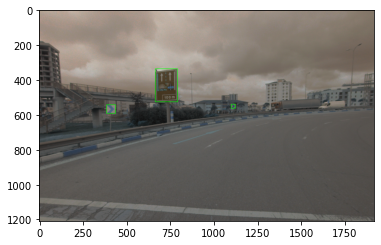

In [7]:
""" Check the function """ 

# Read the line from allLabel.txt
with open(OD_LABEL, 'r') as f:
    line = f.readline()
    visualize(line)   
    

In [8]:
""" Write a helper function to crop the bounding box and return cropped image """
def cropped_image(image_path, X_up,Y_up, X_bottom, Y_bottom):
    """
    

    Parameters
    ----------
    image_path : string
        Path to image.
    X_up : int
        Up Left X coordinate.
    Y_up : int
        Up Left Y coordinate.
    X_bottom : int
        Right Bottom X coordinate.
    Y_bottom : int
        Right Bottom Y coordinate.

    Returns
    -------
    crop_img : array of uint8
        Cropped image.

    """
    img = cv2.imread(image_path)
    w = X_bottom - X_up
    h = Y_bottom - Y_up
    crop_img = img[Y_up:Y_up+h, X_up:X_up+w]
    
    
    return crop_img

<function matplotlib.pyplot.show(*args, **kw)>

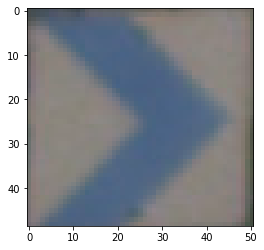

In [9]:
""" Check the function """ 

# Constants
image_path = "data/images/cfc_000234.jpg"
X_up,Y_up, X_bottom, Y_bottom = 387,542,438,591

# Check
cropped = cropped_image(image_path, X_up, Y_up, X_bottom, Y_bottom)
plt.imshow(cropped)
plt.show



# Step 5: Build Model

## Lecture
Similar to Project 1, the model is constructed as a class to call easily. Example object recognition model ideas are here: 

- R-CNN and its variance
- YOLO and its variance

## Practice

In [ ]:
class ObjectRecognitionModel(nn.Module):
    def __init__(self, ..., ...):
        super(FoInternNet, self).__init__()
        ...

    def forward(self, x):
        ...
        return x



if __name__ == '__main__':
    model = ObjectRecognitionModel(...)

# Step 6: Train

## Practice

The training process is defined stepwise. Not only for this project but all project has similar steps. To visualize your result, you may use the [Weights and Biases library](https://wandb.ai/site).

In [ ]:
# Define an optimizer with learning rate 0.001 (for beginning)
optimizer = ##FILL HERE##
print(optimizer)

In [ ]:
# Decide which loss function to use from torch.nn module and define it below
loss_fn = ## FILL HERE ##

In [ ]:
# Call model
model = ObjectRecognitionModel(...)

# If cuda is used, import the cuda
if cuda:
    model = model.cuda()

In [ ]:
# Train the model. After this cell, plot the loss vs iteration graph for train and val set. 
EPOCH = ...
for epoch in range(EPOCH):
    ...

In [ ]:
# Test your network on the test set: Compare the model output and test set output to reach the result
## FILL HERE ##

# Step 7: Check The Results

## Lecture

- What is Bayes (Optimal) Error?

It is a theoretical limit that the best possible error. You cannot do better than Bayes error unless overfitting.

- Why is Human-Level Performance?

ML algorithms and advances in DL create much better algorithms. It is feasible to become competitive with human-level performance. 

Also, it is efficient if workflow of designing and building ML systems.

- What do you think about the Bayes Error and Human-Level Performance of Image recognition task?

They are almost zero because humans are flawless in vision tasks. 

- What is bias in ML?
- What is avoidable bias?
- What is variance in ML?

> For Bias and Variance, Andrew NG states, "Easy to learn difficult to master."

- How to understand the model has a bias?
- How to understand the model has variance?
- In the previous era, there is a trade-off between bias and variance. Why is there not any deterministic trade-off between them?

Would you please fill in according to error values as high/low variance and/or high/low bias?

There is a recipe from Andrew Ng:

![Basic Recipe](bias_var.png)

### Regularization

- Why do we need regularization?

Because there may not always have enough data.

- Why regularization reduces overfitting?
- One of the regularization methods is a dropout. What does it?
- Do you think that using dropout in validation and test time is logical?

No! Because we do not output randomly created. It just adds noise to the predictions.

> Andrew NG introduces 2 different intuitions for dropout. Without dive into mathematics, you may want to watch them.

- What are the other regularization methods?

### Optimization

- Why do we need the normalization of inputs?
- If we apply normalization for the training set, do we have to apply it for the dev/test set?
- What do vanishing and exploding gradients?
- As a partial solution for the vanishing and exploding gradient problem, weight initialization is suggested. Why?

## BONUS
After training the Object recognition model, create a new dataset using the bounding box points that the model predicted. Examine the test performance on your dataset created by training this dataset of traffic signs with the German traffic signs dataset. You can benefit from the progress of the above steps while designing this new project. The new dataset you created will not have labels. 
  
>The bonus project is the image classification task. The input-output relationship will be different from object recognition. The cropped_image() function may help you. 
